<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/brist1d_blood_glucose_prediction_tabnet_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BrisT1D Blood Glucose Prediction with TabNet V0

In [1]:
%%capture
!pip install -qq pytorch_tabnet
!!pip install optuna
!pip install optuna-integration-pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [4]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [5]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [6]:
df_train.shape

(177024, 507)

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [7]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = df_train[colset].interpolate(axis=1)
    df_test[colset] = df_test[colset].interpolate(axis=1)

In [8]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [9]:
imputer = SimpleImputer(strategy="mean")

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [10]:
df_train[feature_cols].isna().sum()

,0
bg-0-00,0
bg-0-05,0
bg-0-10,0
bg-0-15,0
bg-0-20,0
...,...
cals-0-35,0
cals-0-40,0
cals-0-45,0
cals-0-50,0


## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [11]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [12]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [13]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

In [14]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,27254
bg-5-50,18491
bg-5-45,13660
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
X = df_train[feature_cols]
y = df_train[[target_col]]

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

In [ ]:
X = df_train[feature_cols]
y = df_train[[target_col]]
groups = df_train[group_col]
cv = GroupKFold(5)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v1/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v0.csv")

# BrisT1D BGP with TabNet V1

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(10):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

In [ ]:
df_train.isna().sum()

## Training & Inference


In [ ]:
new_train

X = df_train[feature_cols]
y = df_train[[target_col]]

In [ ]:
# X.columns

# print(feature_cols)

X.head(3)#.isna().sum().sum()

In [ ]:
new_train[feature_cols].tail(3)

In [ ]:
#pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)

In [ ]:
# new_train.shape,X.shape
# plt.plot(y)

In [ ]:
X = df_train[feature_cols]
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(7)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v1/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

df_subm.to_csv('submission_tabnet.csv')

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v1.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v1.csv")

# BrisT1D BGP with TabNet V2

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(10):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

In [ ]:
df_train.isna().sum()

## Training & Inference


In [ ]:
new_train

X = df_train[feature_cols]
y = df_train[[target_col]]

rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 7

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v2/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v2.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v2.csv")

# BrisT1D BGP with TabNet V3&4

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 7

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v4/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
df_train.reset_index(inplace=True, drop=True)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

def objective(trial,FOLDS=3):
    """
    Objective function for Optuna to optimize TabNetRegressor hyperparameters.

    Args:
        trial: Optuna trial object.
        X: Feature matrix.
        y: Target variable.
        n_splits: Number of cross-validation splits.

    Returns:
        float: Mean cross-validated RMSE.
    """

    # Suggest hyperparameters using Optuna's trial object
    params = {
        "n_d": trial.suggest_int("n_d", 8, 16, step=2),
        "n_a": trial.suggest_int("n_a", 8, 16, step=2),
        "n_steps": trial.suggest_int("n_steps", 3, 5),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "verbose": 0,  # Suppress verbose output during optimization
    }

    # K-fold cross-validation
    kf = GroupKFold(FOLDS)
    rmse_scores = []

    for train_index, val_index in kf.split(X, y, groups=groups):
        X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
        X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

        # Create and train the TabNet model
        model = TabNetRegressor(grouped_features=grouped_features, **params)
        model.fit(
            X_train=X_train,
            y_train=y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=["rmse"],
            max_epochs=15,  # You might need to adjust this
            patience=5,  # Early stopping patience
        )

        # Make predictions and evaluate
        y_pred = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)  # Return the mean RMSE across folds


# --- Example usage ---
# Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# Create an Optuna study
study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# Optimize the objective function
study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# Get the best parameters and results
best_params = study.best_params
best_rmse = study.best_value

print(f"Best RMSE: {best_rmse:.4f}")
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v4.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v4.csv")

# BrisT1D Blood Glucose Prediction with TabNet V5

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X_.isna().sum().sum()

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    params = {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}
    reg = TabNetRegressor(
        grouped_features=grouped_features,**params
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v5/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
# df_train.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train[feature_cols].copy()
# X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
# y = df_train[[target_col]]
# y = pd.concat([y, new_target], axis=0, ignore_index=True)

# X["p_num"].replace(rep_dict, inplace=True)

# groups_0 = df_train[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse:.4f}")
# print("Best hyperparameters:")
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v5.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v5.csv")

# BrisT1D BGP with TabNet V6

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
activity_cols = [f'activity-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + activity_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.float32).values
df_test[list_act] = df_test[list_act].astype(np.float32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, activity_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X_.isna().sum().sum()

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    params = {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}
    reg = TabNetRegressor(
        grouped_features=grouped_features,**params
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v6/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
# df_train.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train[feature_cols].copy()
# X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
# y = df_train[[target_col]]
# y = pd.concat([y, new_target], axis=0, ignore_index=True)

# X["p_num"].replace(rep_dict, inplace=True)

# groups_0 = df_train[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse:.4f}")
# print("Best hyperparameters:")
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v6.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v6.csv")

# BrisT1D BGP with Conv2D-GRU V0

In [15]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [16]:
from tqdm import tqdm
from itertools import product
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from keras.utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
torch.__version__

'2.5.1+cu121'

## Data Variables


<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [18]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '_')
df_train.columns = df_train.columns.str.replace('-', '_')
df_test.columns = df_test.columns.str.replace(':', '_')
df_test.columns = df_test.columns.str.replace('-', '_')

In [19]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

train_cols=df_train.columns.tolist()
# We only need the last 12 time intervals (1 hour)
bg_cols   = [col for col in train_cols if "bg_" in col ][-24:]
insu_cols = [col for col in train_cols if "insulin_" in col ][-24:]
carb_cols = [col for col in train_cols if "carbs_" in col ][-24:]
hr_cols   = [col for col in train_cols if "hr_" in col ][-24:]
step_cols = [col for col in train_cols if "steps_" in col ][-24:]
cals_cols = [col for col in train_cols if "cals_" in col ][-24:]
actv_cols = [col for col in train_cols if "activity_" in col ][-24:]

static = [group_col]

print(len(bg_cols),len(insu_cols),len(carb_cols),len(hr_cols),len(step_cols),len(cals_cols), len(actv_cols), len(static))
feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + actv_cols + static

24 24 24 24 24 24 24 1


## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [20]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.float32).values
df_test[list_act] = df_test[list_act].astype(np.float32).values

df_train[list_act].isna().sum().sum(), df_test[list_act].isna().sum().sum()

(0, 0)

In [21]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

{0.0, 1.0, 2.0, 3.0}

### All the rest

In [22]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [23]:
df_train["bg_5_55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [24]:
activity_cols = df_test.filter(regex="activity_").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1_00']+actv_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [25]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'hr', 'cals', 'insulin', 'activity', 'bg']

### Extract Additional Data:

In [26]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-48-j:-24-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [27]:
new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 172)

In [28]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [29]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [30]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, activity_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [31]:
#grouped_features

## Training & Inference


In [32]:
target_col = 'bg+1_00'

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [33]:
# X.columns

# print(feature_cols)

X_.isna().sum().sum()

0

In [34]:
new_train["bg+1_00"] = new_target.values

X = df_train[feature_cols+["bg+1_00"]].copy()
X = pd.concat([X, new_train[feature_cols+["bg+1_00"]]], axis=0, ignore_index=True)

X_test = df_test[feature_cols].copy()

FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)
X_test["p_num"].replace(rep_dict, inplace=True)

X_test["bg+1_00"] = np.nan

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

In [35]:
X.isna().sum().sum()
#feature_cols

0

In [36]:
X_test.shape, X.shape

((3644, 172), (249904, 172))

## Data Scaling:

In [37]:
X_test

,bg_1_55,bg_1_50,bg_1_45,bg_1_40,bg_1_35,bg_1_30,bg_1_25,bg_1_20,bg_1_15,bg_1_10,...,activity_0_25,activity_0_20,activity_0_15,activity_0_10,activity_0_05,activity_0_00,p_num,sin_hour,cos_hour,bg+1_00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,13.7,13.7,13.766667,13.833333,13.900000,14.133333,14.366667,14.600000,14.433333,14.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.997515,-0.070457,NaN
p01_8460,6.1,6.1,6.100000,5.733333,5.366667,5.000000,4.800000,4.600000,4.400000,4.233333,...,0.0,0.0,0.0,2.0,2.0,2.0,0,0.357460,-0.933929,NaN
p01_8461,5.2,5.2,5.200000,5.233333,5.266667,5.300000,5.100000,4.900000,4.700000,4.766667,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.430438,-0.902620,NaN
p01_8462,3.3,3.3,3.300000,3.433333,3.566667,3.700000,4.166667,4.633333,5.100000,5.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.888565,0.458750,NaN
p01_8463,3.4,3.4,3.400000,3.300000,3.200000,3.100000,3.033333,2.966667,2.900000,3.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.869249,0.494374,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p24_256,6.3,6.8,7.100000,7.200000,6.800000,7.000000,6.900000,7.000000,6.700000,6.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,15,0.998738,-0.050231,NaN
p24_257,6.0,6.8,7.500000,7.700000,7.800000,7.600000,7.400000,7.200000,7.200000,7.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,15,0.101949,-0.994790,NaN
p24_258,9.9,9.9,9.800000,9.700000,9.500000,9.500000,9.500000,9.400000,9.300000,9.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,15,0.790632,0.612292,NaN


In [38]:
#Scale features
df_tmp=pd.concat([X,X_test])
scaler = MinMaxScaler(feature_range=(0,1))
df_tmp[feature_cols[:-3]]=scaler.fit_transform(df_tmp[feature_cols[:-3]])

train=df_tmp[:len(X)]
test=df_tmp[len(X):]
del df_tmp
gc.collect()

60

In [39]:
train.shape, test.shape

((249904, 172), (3644, 172))

#### **Data Management**

In [40]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, target, data_index, train_features, static=['sin_hour', 'cos_hour', 'p_num'], batch_size=1024*10, shuffle=False, mode='train', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = data
        self.target = target
        self.static = static
        self.features = train_features[:-len(self.static)]
        self.data_index = data_index
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.data_index) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        (X0, X1, X2), y = self.__data_generation(indexes)
        return (X0, X1, X2), y

    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.data_index
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X0 = self.data.iloc[indexes][self.features].values
        X1 = self.data.iloc[indexes][self.static[:-1]].values
        X2 = self.data.iloc[indexes][self.static[-1]].values.reshape(-1, 1)
        y = self.data.iloc[indexes][self.target].values

        # Adjust the reshaping of X0 if necessary
        X0 = X0.reshape(len(indexes), 7, -1)

        return (X0, X1, X2), y

In [41]:
test.reset_index(drop=True, inplace=True)

In [42]:
gen = DataGenerator(train,'bg+1_00',train.head(1024).index,train_features=feature_cols,static=['sin_hour','cos_hour',"p_num"],shuffle=False, batch_size=1024,mode='train')
#test_gen=DataGenerator(test.reset_index(drop=True),"bg+1_00",test.index,feature_cols,shuffle=False, batch_size=256,mode='test')
(X0,X1,X2),y=next(gen)

X0.shape,X1.shape,X2.shape,y.shape

((1024, 7, 24), (1024, 2), (1024, 1), (1024,))

(7, 24) 13.4
(1024, 7, 24)


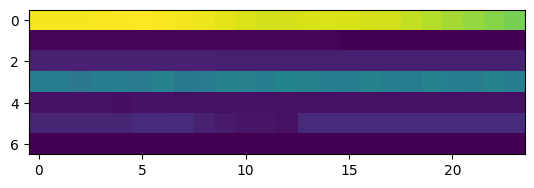

(7, 24) 4.9
(1024, 7, 24)


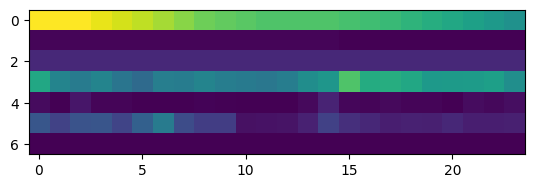

(7, 24) 4.7
(1024, 7, 24)


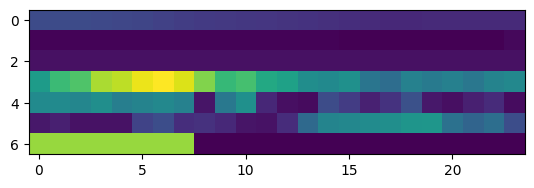

(7, 24) 10.4
(1024, 7, 24)


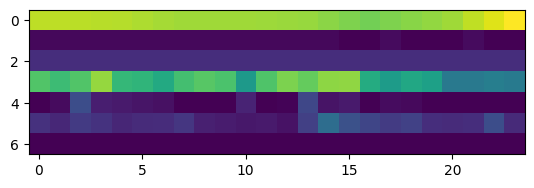

In [43]:
for i in range(0,1024,300):
    print(X0[i].shape,y[i])
    print(X0.shape)
    fig = plt.figure()
    plt.imshow(X0[i])
    plt.show()

In [44]:
len(train.p_num.unique())

16

* **THE MODEL**

In [45]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def make_model(img_rows,img_cols,channnels):

    input_model = tf.keras.layers.Input(shape=(img_rows,img_cols,channnels),name="ts_inputs")
    input_static_0 = tf.keras.layers.Input(shape=(2,),name="time_inputs")
    input_static_1 = tf.keras.layers.Input(shape=(1,))

    ########################################################
    pnum_encoded_embedding = tf.keras.layers.Embedding(input_dim=16,output_dim=5, name="embed_pnum")(input_static_1)
    pnum_encoded_embedding = tf.keras.layers.Flatten(name="flat_pnum")(pnum_encoded_embedding)

    conv1 = tf.keras.layers.Conv2D(64, kernel_size=(7,3), activation='relu')(input_model)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(1,3),padding='same', activation='relu')(conv1)
    conv1 = tf.keras.layers.Reshape((22,32))(conv1)
    GRU1  = tf.keras.layers.GRU(32, return_sequences=True)(conv1)
    GRU1 = tf.keras.layers.Flatten(name="flat_gru")(GRU1)

    concat = tf.keras.layers.concatenate([GRU1,input_static_0,pnum_encoded_embedding], name="concatenate_series")

    x = tf.keras.layers.Dense(128, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[input_model,input_static_0,input_static_1], outputs=output)

    metric_rmse = RootMeanSquaredError(name="rmse", dtype=None)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = 'mse', metrics=[metric_rmse])

    return model


img_rows=7
img_cols=int(len(feature_cols)/7)
channnels=1
model=make_model(img_rows,img_cols,channnels)
model.summary()
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png', rankdir='LR')
# from IPython.display import Image
# Image(retina=True, filename='model.png')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ts_inputs (InputLayer)    │ (None, 7, 24, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1, 22, 64)      │          1,408 │ ts_inputs[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1, 22, 32)      │          6,176 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 22, 32)         │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 22, 32)         │          6,336 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_pnum (Embedding)    │ (None, 1, 5)           │             80 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flat_gru (Flatten)        │ (None, 704)            │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_inputs (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flat_pnum (Flatten)       │ (None, 5)              │              0 │ embed_pnum[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_series        │ (None, 711)            │              0 │ flat_gru[0][0],        │
│ (Concatenate)             │                        │                │ time_inputs[0][0],     │
│                           │                        │                │ flat_pnum[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         91,136 │ concatenate_series[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          4,128 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 109,297 (426.94 KB)

 Trainable params: 109,297 (426.94 KB)

 Non-trainable params: 0 (0.00 B)

* **MODEL GENERAL SETTING**

In [46]:
img_rows=7
img_cols=int((len(feature_cols)-3)/7)
channnels=1

img_rows, img_cols, channnels, (len(feature_cols)-3)/7
i=0
cv = GroupKFold(5)
K.clear_session()
test_gen=DataGenerator(test.reset_index(drop=True),"bg+1_00",test.index,feature_cols,shuffle=False, batch_size=256,mode='test')
train_oof= np.zeros((len(train)))
test_preds= np.zeros((len(test)))
experiment_name = "conv2d_gru_v0"

### **FIT THE MODEL**

In [47]:
for train_index, valid_index in cv.split(train, train["bg+1_00"], groups=train['p_num']):

    print(f"Fold {i}")
    print('train_p_num:',train.iloc[train_index]['p_num'].unique(),'*********  valid_p_num:',train.iloc[valid_index]['p_num'].unique())

    # Define callbacks:
    ##################################################################### Relevant Folders
    folders_experiment = f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/{experiment_name}_{i}/"
    checkpoint_filepath = folders_experiment + f'checkpoint/{experiment_name}.weights.h5'
    # Callbacks:
    es = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=20, verbose=0, mode='min', baseline=None, restore_best_weights=True, start_from_epoch=3)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_rmse', factor=0.5, patience=5,  mode='min', verbose=0)
    check = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_rmse",mode='min',save_best_only=True)
    ##################################################################### Generate and Fit Model

    # Split the data into training and validation sets for the current fold
    train_gen=DataGenerator(train,"bg+1_00",train_index,feature_cols,shuffle=False, batch_size=256,mode='train')
    valid_gen=DataGenerator(train,"bg+1_00",valid_index,feature_cols,shuffle=False, batch_size=256,mode='train')

    print(len(train_index),len(valid_index))

    # Initialize the Conv2D Regressor model
    model=make_model(img_rows,img_cols,channnels)

    # Train the model using the training set and validate using the validation set
    #model.fit(train_gen,validation_data =valid_gen, verbose=1, epochs=100, callbacks = [rlr,es,check])
    model.load_weights(checkpoint_filepath)

    # In and OOF Predictions:
    test_preds += model.predict(test_gen,verbose=0).ravel()/5
    oof_preds = model.predict(valid_gen,verbose=0).ravel()
    train_oof[valid_index] = oof_preds
    ##################################################################### Save the Model
    model.save(f"{folders_experiment}/model_{experiment_name}.keras")

    rmse = root_mean_squared_error(train.iloc[valid_index]["bg+1_00"], oof_preds)
    print(f"RMSE oof Score: {rmse}")

    K.clear_session()
    del model

    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
train_p_num: [ 0  1  2  3  4  5  6  7 11 12 13] *********  valid_p_num: [ 8  9 10 14 15]
198765 51139
RMSE oof Score: 2.2511279945887885
Fold 1
train_p_num: [ 0  2  3  4  6  7  8  9 10 12 13 14 15] *********  valid_p_num: [ 1  5 11]
201809 48095
RMSE oof Score: 2.7966112450651104
Fold 2
train_p_num: [ 1  2  4  5  6  7  8  9 10 11 12 14 15] *********  valid_p_num: [ 0  3 13]
201999 47905
RMSE oof Score: 2.6438721067174247
Fold 3
train_p_num: [ 0  1  2  3  5  7  8  9 10 11 13 14 15] *********  valid_p_num: [ 4  6 12]
202142 47762
RMSE oof Score: 2.033496724385447
Fold 4
train_p_num: [ 0  1  3  4  5  6  8  9 10 11 12 13 14 15] *********  valid_p_num: [2 7]
194901 55003
RMSE oof Score: 2.261768073099592


## Save Results:

In [50]:
df_subm.shape, test_preds.shape

((3644, 1), (3644,))

In [52]:
df_subm["bg+1:00"]=test_preds

In [53]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_conv2d_gru_v0.csv')

In [59]:
train_oof = pd.DataFrame(train_oof, columns=["gru_v0"])

In [60]:
train_oof.head()

,gru_v0
0,11.055593
1,10.693542
2,10.447989
3,10.730049
4,10.406809


In [62]:
train_oof.isna().sum()

,0
gru_v0,0


In [63]:
train_oof.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_gru_v0.csv")

# BrisT1D BGP with StackedRegressor V0

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = "bg+1-00"  # Target column name for prediction
group_col = "p_num"  # Column name for grouping (e.g., participant number)
date_col = "time"  # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols = [f"bg-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
insu_cols = [f"insulin-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
carb_cols = [f"carbs-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
hr_cols = [f"hr-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
step_cols = [f"steps-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
cals_cols = [f"cals-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [ ]:
import random
import os
import numpy as np
import torch


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
seed = 43  #
Thr_NAN = 49
seed_everything(seed)

In [ ]:
# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(":", "-")
df_test.columns = df_test.columns.str.replace(":", "-")


for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#mask = df_train[feature_cols].isna().sum(axis=1) <= Thr_NAN
# Apply the mask to filter the rows
#df_train = df_train[mask]

imputer = SimpleImputer()

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [ ]:
df_train.shape

In [ ]:
df_train["sin_hour"] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train["cos_hour"] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test["sin_hour"] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test["cos_hour"] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(["sin_hour", "cos_hour"])


grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)


df_train_final = df_train[feature_cols]
groups = df_train[group_col]

y_target = df_train[[target_col]]

df_test_final = df_test[feature_cols]

In [ ]:
df_train_final.columns

## Train the Model:

In [ ]:
%%capture
!pip install skops
!pip install catboost

In [ ]:
import skops.io as sio

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

X_test = df_test_final.to_numpy()

groups = df_train[group_col]
cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v00_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

## Save Results:

In [ ]:
df_subm_stack.head()

In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v00.csv')

In [ ]:
oof_results_stack.head()

In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

In [ ]:
oof_results_stack.isna().sum()

In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v00.csv")

In [ ]:
tab = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
stack = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv', index_col='id')

In [ ]:
ensemble_v0 = (tab+stack)/2

In [ ]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v0.csv')

# BrisT1D BGP with StackedRegressor V1 - V2 - V3

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [ ]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
X.columns

In [ ]:
new_train[feature_cols].columns

In [ ]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape,X_test.shape

In [ ]:
df_test_final = df_test[feature_cols]
df_test_final.head(3)

## Train the Model:

In [ ]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [ ]:
import skops.io as sio
import category_encoders as ce

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v3_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

## Save Results:

In [ ]:
df_subm_stack.head()

In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v3.csv')

In [ ]:
oof_results_stack.head()

In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

In [ ]:
oof_results_stack.isna().sum()

In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v3.csv")

# BrisT1D BGP with StackedRegressor V4

Add Activity to the features

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
import torch

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
activity_cols = [f'activity-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + activity_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.int32).values
df_test[list_act] = df_test[list_act].astype(np.int32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [ ]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
X.columns

In [ ]:
new_train[feature_cols].columns

In [ ]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape,X_test.shape

In [ ]:
df_test_final = df_test[feature_cols]
df_test_final.head(3)

## Train the Model:

### Training:

In [ ]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [ ]:
import skops.io as sio
import category_encoders as ce

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v4_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

## Save Results:

In [ ]:
df_subm_stack.head()

In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v4.csv')

In [ ]:
oof_results_stack.head()

In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

In [ ]:
oof_results_stack.isna().sum()

In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v4.csv")

# BrisT1D BGP with StackedRegressor V5

The stacked Models here include some regularization constraints.

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
import torch

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
torch.__version__

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
activity_cols = [f'activity-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static + activity_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [ ]:
list_act = df_train.filter(regex="activity").columns.to_list()

act_to_replace = {"Indoor climbing":1,
                  "Run":3,
                  "Strength training":3,
                  "Swim":3,
                  "Bike":3,
                  "Dancing":2,
                  "Stairclimber":2,
                  "Spinning":3,
                  "Walking":2,
                  "HIIT":3,
                  "Cycling":3,
                  "Outdoor Bike":3,
                  "CoreTraining":3,
                  "Walk":2,
                  "Aerobic Workout":3,
                  "Tennis":2,
                  "Workout":3,
                  "Hike":2,
                  "Zumba":2,
                  "Sport":2,
                  "Yoga":1,
                  "Swimming":3,
                  "Weights":3,
                  "Running":3}


df_train.replace(act_to_replace, inplace=True)
df_train[list_act] = df_train[list_act].fillna(0).values

df_test.replace(act_to_replace, inplace=True)
df_test[list_act] = df_test[list_act].fillna(0).values

df_train[list_act] = df_train[list_act].astype(np.int32).values
df_test[list_act] = df_test[list_act].astype(np.int32).values

df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

In [ ]:
thisset = set()

for col in list_act:
  for act in df_train[col].unique():
    thisset.add(act)
  for act in df_test[col].unique():
    thisset.add(act)

thisset

### All the rest

In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

In [ ]:
df_train.shape

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [ ]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
X.columns

In [ ]:
new_train[feature_cols].columns

In [ ]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape,X_test.shape

In [ ]:
df_test_final = df_test[feature_cols]
df_test_final.head(3)

## Train the Model:

### Model Hyperparameter Tuning:

In [ ]:
#df_train_final.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train_final.copy()
# y = y_target.copy()

# X["p_num"].replace(rep_dict, inplace=True)

# groups = df_train_final[group_col]

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# # print(f"Best RMSE: {best_rmse:.4f}")
# # print("Best hyperparameters:")
# # for key, value in best_params.items():
# #     print(f"  {key}: {value}")

### Training:

In [ ]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [ ]:
import skops.io as sio
import category_encoders as ce

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95, reg_lambda=0.0001, reg_alpha=0.0001)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90, reg_lambda=0.0001, reg_alpha=0.0001)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9, l2_leaf_reg=0.0001))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v5_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

## Save Results:

In [ ]:
df_subm_stack.head()

In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v5.csv')

In [ ]:
oof_results_stack.head()

In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

In [ ]:
oof_results_stack.isna().sum()

In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v5.csv")

# BrisT1D BGP with StackedRegressor V6

V3 + [Mean, std, skew]
No Activity and Regularization

In [315]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
import torch

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [316]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [317]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [318]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [319]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


### Fill Activity:

In [320]:
# list_act = df_train.filter(regex="activity").columns.to_list()

# act_to_replace = {"Indoor climbing":1,
#                   "Run":3,
#                   "Strength training":3,
#                   "Swim":3,
#                   "Bike":3,
#                   "Dancing":2,
#                   "Stairclimber":2,
#                   "Spinning":3,
#                   "Walking":2,
#                   "HIIT":3,
#                   "Cycling":3,
#                   "Outdoor Bike":3,
#                   "CoreTraining":3,
#                   "Walk":2,
#                   "Aerobic Workout":3,
#                   "Tennis":2,
#                   "Workout":3,
#                   "Hike":2,
#                   "Zumba":2,
#                   "Sport":2,
#                   "Yoga":1,
#                   "Swimming":3,
#                   "Weights":3,
#                   "Running":3}


# df_train.replace(act_to_replace, inplace=True)
# df_train[list_act] = df_train[list_act].fillna(0).values

# df_test.replace(act_to_replace, inplace=True)
# df_test[list_act] = df_test[list_act].fillna(0).values

# df_train[list_act] = df_train[list_act].astype(np.int32).values
# df_test[list_act] = df_test[list_act].astype(np.int32).values

# df_train[list_act].isna().sum().sum(), df_test[activity_cols].isna().sum().sum()

In [321]:
# thisset = set()

# for col in list_act:
#   for act in df_train[col].unique():
#     thisset.add(act)
#   for act in df_test[col].unique():
#     thisset.add(act)

# thisset

### All the rest

In [322]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [323]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [324]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [325]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['insulin', 'steps', 'hr', 'activity', 'cals', 'carbs', 'bg']

In [326]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

### Extract Additional Data:

In [327]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(30):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [328]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(109320, 88)

In [329]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [330]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

df_train.shape, df_test.shape

((177024, 509), (3644, 508))

## Training & Inference


In [331]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [332]:
#X_.columns

In [333]:
#new_train[feature_cols].columns

In [334]:
df_train_final = pd.concat([df_train[feature_cols+["time"]], new_train[feature_cols+["time"]]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)
df_train_final["bg+1-00"] = y_target

In [335]:
df_test_final = df_test[feature_cols+["time"]]
#df_test_final.head(3)

In [336]:
df_train_final.shape, y_target.shape,df_test_final.shape

((286344, 77), (286344, 1), (3644, 76))

## Feature Engeneering:

* **

In [337]:
print(df_train_final.shape)
ver = df_train_final.groupby(["p_num", "time"], as_index=False)["bg+1-00"].agg(["mean","std","skew"])
df_train_final = df_train_final.merge(ver, on=["p_num", "time"], how="left")
df_train_final.shape

(286344, 77)


(286344, 80)

In [338]:
print(df_test_final.shape)
df_test_final = df_test_final.merge(ver, on=["p_num", "time"], how="left")
df_test_final.fillna(df_train_final["bg+1-00"].median(), inplace=True)
df_test_final.shape

(3644, 76)


(3644, 79)

In [339]:
df_train_final.filter(regex="insulin").mean(axis=1)

,0
0,0.055533
1,0.051383
2,0.047233
3,0.043083
4,0.041700
...,...
286339,0.074233
286340,0.067283
286341,0.213233
286342,0.068183


In [340]:
print(df_train_final.shape, df_test_final.shape)
df_train_final["insul_total"] = df_train_final.filter(regex="insulin").mean(axis=1).values
df_test_final["insul_total"] = df_test_final.filter(regex="insulin").mean(axis=1).values
df_train_final.shape, df_test_final.shape

(286344, 80) (3644, 79)


((286344, 81), (3644, 80))

In [341]:
feature_cols.extend(["mean","std","skew","insul_total"])
static.extend(["mean","std","skew","insul_total"])

In [342]:
df_test_final["mean"].isna().sum(), df_train_final["mean"].isna().sum()

(0, 0)

In [343]:
df_train_final.drop(columns=["time","bg+1-00"], inplace=True)
df_test_final.drop(columns=["time"], inplace=True)

In [344]:
y_target.reset_index(drop=True, inplace=True)

In [345]:
df_test_final.shape, df_train_final.shape, y_target.shape

((3644, 79), (286344, 79), (286344, 1))

In [346]:
df_train_final.head(3)

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,cals-0-10,cals-0-05,cals-0-00,p_num,sin_hour,cos_hour,mean,std,skew,insul_total
0,17.5,17.5,17.5,17.433333,17.366667,17.3,16.933333,16.566667,16.2,15.833333,...,9.22529,9.222623,9.211014,p01,1.0,6.123234e-17,9.947798,4.534129,-0.060173,0.055533
1,17.3,17.3,17.3,16.933333,16.566667,16.2,15.833333,15.466667,15.1,14.866667,...,9.22529,9.222623,9.211014,p01,1.0,6.123234e-17,9.803724,4.395667,-0.015882,0.051383
2,16.2,16.2,16.2,15.833333,15.466667,15.1,14.866667,14.633333,14.4,14.233333,...,9.22529,9.222623,9.211014,p01,1.0,6.123234e-17,9.600859,4.316183,0.121731,0.047233


In [347]:
y_target.head()

,bg+1-00
0,13.4
1,12.8
2,15.5
3,14.8
4,12.7


## Train the Model:

### Training:

In [348]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [349]:
import skops.io as sio
import category_encoders as ce

In [305]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)

X_test = df_test_final.copy()
X_test["p_num"] = encoder_.transform(X_test["p_num"])
X_test = X_test.values

groups = df_train_final[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v6_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Fold 0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18200
[LightGBM] [Info] Number of data points in the train set: 228825, number of used features: 79
[LightGBM] [Info] Start training from score 8.418039
Learning rate set to 0.039544
0:	learn: 2.9035020	total: 32.5ms	remaining: 1m 37s
1:	learn: 2.8559904	total: 58.1ms	remaining: 1m 27s
2:	learn: 2.8114568	total: 86.5ms	remaining: 1m 26s
3:	learn: 2.7689283	total: 112ms	remaining: 1m 23s
4:	learn: 2.7286225	total: 139ms	remaining: 1m 23s
5:	learn: 2.6908296	total: 165ms	remaining: 1m 22s
6:	learn: 2.6556193	total: 193ms	remaining: 1m 22s
7:	learn: 2.6231158	total: 221ms	remaining: 1m 22s
8:	learn: 2.5916027	total: 249ms	remaining: 1m 22s
9:	learn: 2.5622566	total: 275ms	remaining: 1m 22s
10:	learn: 2.5348157	total: 305ms	remainin

## Save Results:

In [ ]:
df_subm_stack.head()

In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v6.csv')

In [ ]:
oof_results_stack.head()

In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

In [ ]:
oof_results_stack.isna().sum()

In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v6.csv")

# ENSEMBLE

In [15]:
tab_v0 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
tab_v1 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v1.csv', index_col='id')
tab_v2 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v2.csv', index_col='id')
tab_v3 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v3.csv', index_col='id')
tab_v4 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v4.csv', index_col='id')
tab_v5 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v5.csv', index_col='id')
tab_v6 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v6.csv', index_col='id')
gru_v0 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_conv2d_gru_v0.csv', index_col='id')
stack_v0 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v00.csv', index_col='id')
#stack_v1 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v1.csv', index_col='id')
#stack_v2 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v2.csv', index_col='id')
stack_v3 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v3.csv', index_col='id')
stack_v4 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v4.csv', index_col='id')
stack_v5 = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v5.csv', index_col='id')

In [17]:
all_pred = pd.concat([tab_v0, tab_v1, tab_v2, tab_v3, tab_v4,tab_v5,tab_v6, gru_v0, stack_v0, stack_v3, stack_v4, stack_v5], axis=1)
new_cols = ["tab_v0", "tab_v1", "tab_v2", "tab_v3", "tab_v4", "tab_v5", "tab_v6", "gru_v0","stack_v00", "stack_v3", "stack_v4", "stack_5"]

all_pred.columns = new_cols
all_pred.head()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,gru_v0,stack_v00,stack_v3,stack_v4,stack_5
id,,,,,,,,,,,,
p01_8459,8.972011,8.631357,9.007207,8.886633,8.682322,8.480623,8.691166,8.490652,8.955641,9.049269,9.071761,9.020909
p01_8460,5.830921,6.126371,5.922358,6.217158,6.385798,6.460919,5.699505,6.316576,5.817060,5.350518,5.328560,5.172157
p01_8461,7.794858,7.723211,8.111410,8.031332,7.867571,8.065517,7.843000,7.488294,8.069355,8.461572,8.350876,8.273953
p01_8462,10.844385,10.624363,10.851858,10.961331,10.428039,10.614953,10.550740,10.449397,10.595205,10.905890,10.917129,10.923623
p01_8463,6.398709,6.908243,7.251251,7.285986,6.939459,6.733258,7.004242,6.597289,7.145713,6.868887,6.947113,6.935257


In [18]:
all_pred.corr()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,gru_v0,stack_v00,stack_v3,stack_v4,stack_5
tab_v0,1.000000,0.987055,0.983541,0.980647,0.983113,0.983766,0.985186,0.933416,0.957399,0.950727,0.950585,0.952526
tab_v1,0.987055,1.000000,0.987940,0.986137,0.987844,0.989929,0.989700,0.937480,0.962556,0.958250,0.958048,0.959618
tab_v2,0.983541,0.987940,1.000000,0.992890,0.995000,0.993073,0.991341,0.944248,0.958142,0.957976,0.958170,0.960097
tab_v3,0.980647,0.986137,0.992890,1.000000,0.994713,0.993645,0.991215,0.949398,0.958860,0.963393,0.963356,0.965207
tab_v4,0.983113,0.987844,0.995000,0.994713,1.000000,0.994717,0.991861,0.950507,0.958439,0.960642,0.960821,0.962648
tab_v5,0.983766,0.989929,0.993073,0.993645,0.994717,1.000000,0.991700,0.946030,0.960383,0.963439,0.963353,0.965072
tab_v6,0.985186,0.989700,0.991341,0.991215,0.991861,0.991700,1.000000,0.945558,0.958786,0.957708,0.957735,0.959558
gru_v0,0.933416,0.937480,0.944248,0.949398,0.950507,0.946030,0.945558,1.000000,0.926807,0.935130,0.936283,0.937783
stack_v00,0.957399,0.962556,0.958142,0.958860,0.958439,0.960383,0.958786,0.926807,1.000000,0.976487,0.976303,0.976474
stack_v3,0.950727,0.958250,0.957976,0.963393,0.960642,0.963439,0.957708,0.935130,0.976487,1.000000,0.998612,0.998479


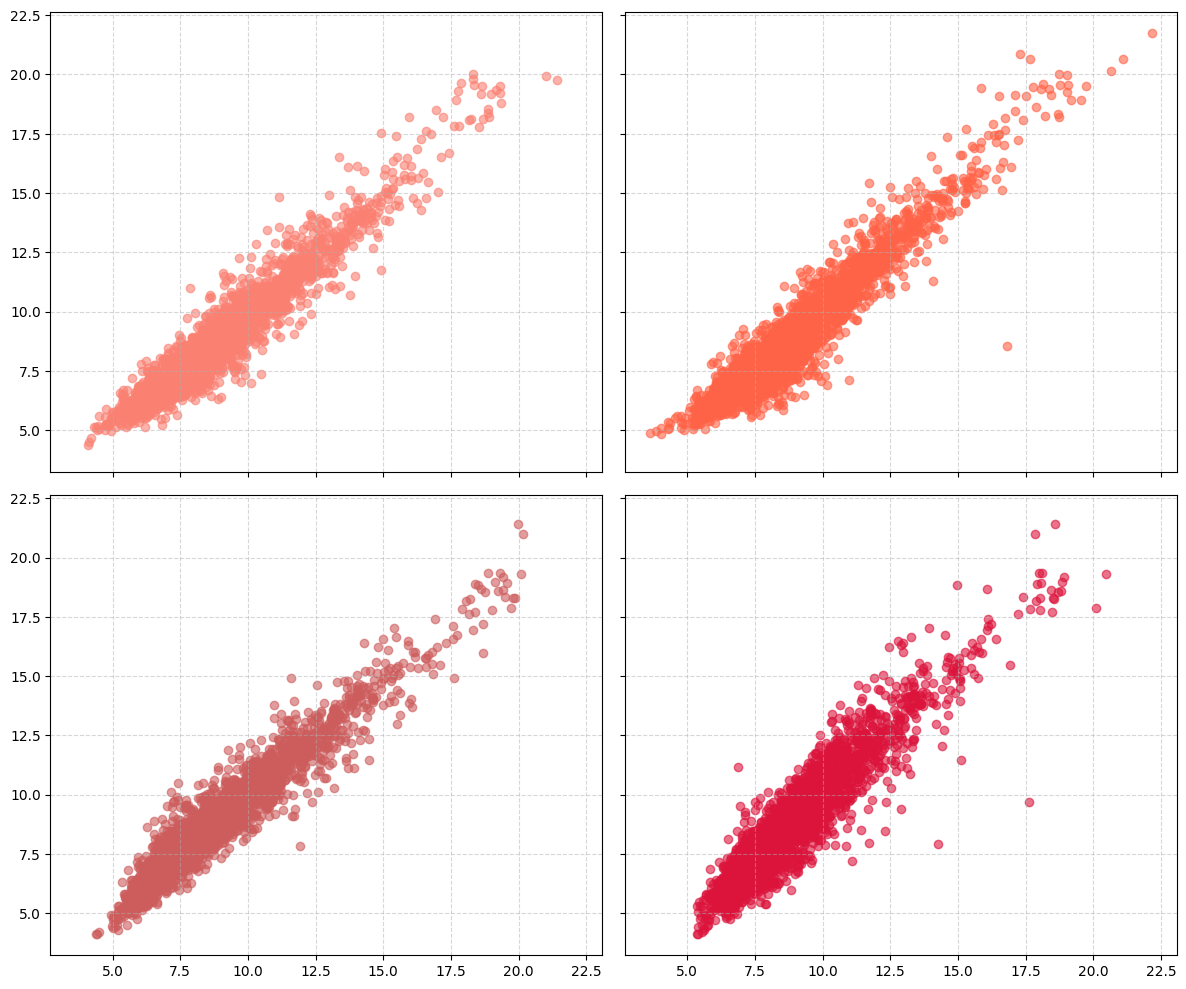

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = np.ravel(axs)
axs[0].scatter(all_pred["stack_v3"], all_pred["tab_v5"], color="salmon", alpha=0.6)
axs[1].scatter(all_pred["stack_v00"], all_pred["tab_v0"], color="tomato", alpha=0.6)
axs[2].scatter(all_pred["tab_v3"], all_pred["stack_v3"], color="indianred", alpha=0.6)
axs[3].scatter(all_pred["gru_v0"], all_pred["stack_v3"], color="crimson", alpha=0.6)

for ax in axs:
    ax.grid(linestyle = "--", alpha=0.5, )

plt.tight_layout()

plt.show()

In [19]:
tab_v0_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v0.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v1_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v1.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v2_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v2.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v3_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v3.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v4_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v4.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v5_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v5.csv', index_col=0).reset_index( drop=True).iloc[:177024]
tab_v6_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v6.csv', index_col=0).reset_index( drop=True).iloc[:177024]
stack_v0_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v00.csv', index_col=0).reset_index( drop=True).iloc[:177024]
gru_v0_train = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_gru_v0.csv", index_col=0).reset_index( drop=True).iloc[:177024]
#stack_v1_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v1.csv', index_col='id').reset_index( drop=True).iloc[:177024]
#stack_v2_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v2.csv', index_col='id').reset_index( drop=True).iloc[:177024]
stack_v3_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v3.csv', index_col=0).reset_index( drop=True).iloc[:177024]
stack_v4_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v4.csv', index_col=0).reset_index( drop=True).iloc[:177024]
stack_v5_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v5.csv', index_col=0).reset_index( drop=True).iloc[:177024]

In [20]:
all_train = pd.concat([tab_v0_train, tab_v1_train, tab_v2_train, tab_v3_train, tab_v4_train,tab_v5_train,tab_v6_train,gru_v0, stack_v0_train, stack_v3_train, stack_v4_train, stack_v5_train], axis=1)

In [21]:
df_train.shape,all_train.shape

((177024, 509), (180668, 12))

In [22]:
new_cols = ["tab_v0", "tab_v1", "tab_v2", "tab_v3", "tab_v4", "tab_v5", "tab_v6", "gru_v0","stack_v00", "stack_v3", "stack_v4", "stack_v5"]
all_train.columns = new_cols
all_train.head()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,gru_v0,stack_v00,stack_v3,stack_v4,stack_v5
0,13.334588,11.736980,14.161020,12.372825,11.174798,12.240019,11.767273,NaN,13.092719,13.389330,13.592894,13.490589
1,12.762192,11.303996,13.622066,11.805146,10.628863,11.708904,11.440390,NaN,12.697700,13.180389,13.410120,12.956067
2,12.500320,11.140917,13.333781,11.650768,10.553446,11.555810,11.119031,NaN,12.592695,13.589884,13.515598,13.240179
3,12.799201,11.685648,13.562715,12.054002,11.087376,11.908131,11.430658,NaN,13.100219,13.759837,13.663587,13.547885
4,12.184162,11.166823,13.082964,11.553975,10.675967,11.418094,10.874480,NaN,12.225832,12.952147,12.645470,12.511294


In [23]:
all_train.corr()

,tab_v0,tab_v1,tab_v2,tab_v3,tab_v4,tab_v5,tab_v6,gru_v0,stack_v00,stack_v3,stack_v4,stack_v5
tab_v0,1.000000,0.967931,0.951683,0.939413,0.958915,0.963251,0.958374,NaN,0.931659,0.920257,0.919581,0.923248
tab_v1,0.967931,1.000000,0.951640,0.951015,0.962553,0.968392,0.962717,NaN,0.939245,0.929311,0.928050,0.931408
tab_v2,0.951683,0.951640,1.000000,0.953843,0.960112,0.962426,0.956453,NaN,0.927565,0.926172,0.925376,0.928554
tab_v3,0.939413,0.951015,0.953843,1.000000,0.962813,0.962933,0.950387,NaN,0.930540,0.921246,0.920140,0.922527
tab_v4,0.958915,0.962553,0.960112,0.962813,1.000000,0.971948,0.966823,NaN,0.931303,0.920700,0.919807,0.923579
tab_v5,0.963251,0.968392,0.962426,0.962933,0.971948,1.000000,0.970975,NaN,0.936587,0.927443,0.926695,0.930015
tab_v6,0.958374,0.962717,0.956453,0.950387,0.966823,0.970975,1.000000,NaN,0.930242,0.923996,0.923665,0.927177
gru_v0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
stack_v00,0.931659,0.939245,0.927565,0.930540,0.931303,0.936587,0.930242,NaN,1.000000,0.939021,0.938887,0.939092
stack_v3,0.920257,0.929311,0.926172,0.921246,0.920700,0.927443,0.923996,NaN,0.939021,1.000000,0.994704,0.994473


In [ ]:
y_target = df_train["bg+1-00"]

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import Ridge, Lasso

X = all_train.copy()
y = y_target.copy()

def objective(trial,FOLDS=5):
    """
    Objective function for Optuna to optimize TabNetRegressor hyperparameters.

    Args:
        trial: Optuna trial object.
        X: Feature matrix.
        y: Target variable.
        n_splits: Number of cross-validation splits.

    Returns:
        float: Mean cross-validated RMSE.
    """

    # Suggest hyperparameters using Optuna's trial object
    params = {
            "alpha": trial.suggest_float('alpha', 1e-5, 100.0, log=True)
             }

    # K-fold cross-validation
    cv = KFold(FOLDS, shuffle=True, random_state=42)

    # Initialize Ridge regressor with suggested hyperparameters
    reg = Lasso(positive=True, random_state=42, **params)
    scores = cross_val_score(reg, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    return -np.mean(scores)  # Return the mean RMSE across folds


# --- Example usage ---
# Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# Create an Optuna study
study = optuna.create_study(direction="minimize", study_name="ensemble_tuning")

# Optimize the objective function
study.optimize(lambda trial: objective(trial), n_trials=200)  # Adjust n_trials

# Get the best parameters and results
best_params = study.best_params
best_rmse = study.best_value

In [ ]:
best_params = {'alpha': 0.00001}

In [ ]:
params = {
            "alpha": 0.00001
             }
cv = KFold(FOLDS, shuffle=True, random_state=42)
reg = Lasso(positive=True, random_state=42, **params)
scores = cross_val_score(reg, X, y, cv=cv, scoring="neg_root_mean_squared_error")

In [ ]:
scores

In [ ]:
scores

In [ ]:
reg.fit(X,y)

In [ ]:
np.sum(reg.coef_)

In [ ]:
weights = reg.coef_/np.sum(reg.coef_)

weights

In [ ]:
np.sum(weights)

In [ ]:
# Calculate the weighted average
all_pred['bg+1:00'] = all_pred.apply(lambda row: sum(row[col] * weight for col, weight in zip(all_pred.columns[:11], weights)), axis=1)

In [ ]:
all_pred

In [ ]:
ensemble_v0 = all_pred['bg+1:00']
ensemble_v0.rename({'weighted_avg':"bg+1:00"}, inplace=True)
ensemble_v0

In [ ]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v1.csv')

In [110]:
ensemble_v2 = (stack_v3+tab_v5)/2
ensemble_v2.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v2.csv')